## Import Libraries

In [492]:
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn import preprocessing
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix, recall_score, precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

## Load Data

In [493]:
changeJobDf = pd.read_csv('A2_change_job_labeled.csv')
changeJobDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11494 entries, 0 to 11493
Data columns (total 73 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   cid                     11494 non-null  int64  
 1   city.100                11494 non-null  int64  
 2   city.10                 11494 non-null  int64  
 3   city.105                11494 non-null  int64  
 4   city.103                11494 non-null  int64  
 5   city.104                11494 non-null  int64  
 6   city.102                11494 non-null  int64  
 7   city.101                11494 non-null  int64  
 8   city.2119               11494 non-null  int64  
 9   city.114                11494 non-null  int64  
 10  city.2341               11494 non-null  int64  
 11  city.116                11494 non-null  int64  
 12  city.123                11494 non-null  int64  
 13  city.128                11494 non-null  int64  
 14  city.2194               11494 non-null

## EDA

In [494]:
print("--- Dataset Overview ---")
changeJobDfCount = changeJobDf.shape[0]
print(f"Number of training data rows: {changeJobDfCount}...")

print("\n--- Checking for null values ---")
missingCount = changeJobDf.isna().sum()
missingCount = len(missingCount[missingCount > 1])
print(f"Missing values in train df: {missingCount}...")

print("\n--- Checking for empty/whitespace-only reviews ---")
emptyCountTrainCount = changeJobDf.eq('').sum()
emptyCountTrainCount = len(emptyCountTrainCount[emptyCountTrainCount > 1])
print(f"Number of empty/whitespace-only reviews: {emptyCountTrainCount}...")

print("\n--- Checking for duplicates ---")
duplicateRowCount = changeJobDf.duplicated().sum()
print(f"Number of duplicate rows: {duplicateRowCount}...")

--- Dataset Overview ---
Number of training data rows: 11494...

--- Checking for null values ---
Missing values in train df: 0...

--- Checking for empty/whitespace-only reviews ---
Number of empty/whitespace-only reviews: 0...

--- Checking for duplicates ---
Number of duplicate rows: 0...


## Check Depndendent/Target Variable Distribution

Target distribution: target
no     8676
yes    2818
Name: count, dtype: int64
Percentages: target
no     75.48
yes    24.52
Name: count, dtype: float64


Text(0, 0.5, 'Count')

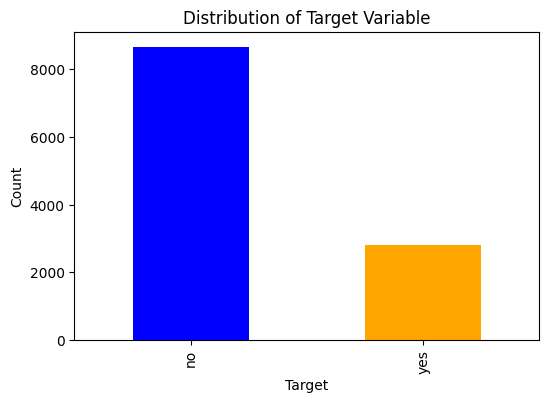

In [495]:
# Calculate value counts
targetCounts = changeJobDf['target'].value_counts()
targetPercent = (targetCounts / targetCounts.sum()) * 100
print(f"Target distribution: {targetCounts}")
print(f"Percentages: {targetPercent.round(2)}")

# Create the plot
plt.figure(figsize=(6, 4))

# Use a bar chart
targetCounts.plot(kind='bar', color=['Blue', 'Orange'])
plt.title('Distribution of Target Variable')
plt.xlabel('Target')
plt.ylabel('Count')

## Remove Field

In [496]:
jobChangeDfTest = pd.read_csv('A2_change_job_submission.csv')
cidTestDf = pd.merge(jobChangeDfTest,changeJobDf,how='inner',on='cid')

# If cid empty then there are no overlapping ID's between test and train
if cidTestDf.empty:
    changeJobDf = changeJobDf.drop(columns='cid')

## Check unique values for non numeric fields

In [497]:
nonNumericCols = changeJobDf.select_dtypes(exclude=[np.number]).columns
print("--- Non-numeric Field Unique Values ---")
for col in nonNumericCols:
    print(f"{col}: {changeJobDf[col].unique()}")

--- Non-numeric Field Unique Values ---
gender: ['Male' 'Other' 'Female']
enrolled_university: ['No enrollment' 'Full time' 'Part time']
education_level: ['Undergraduate' 'High School' 'PhD' 'Primary School' 'Masters']
academic_discipline: ['STEM' 'No major' 'Humanities' 'Other' 'Business degree' 'Arts']
experience: ['15' '4' '8' '2' '7' '5' '13' '3' '6' '19' '>20' '1' '16' '20' '10' '<1'
 '9' '11' '18' '14' '17' '12']
company_size: ['100-500' '50-99' '5000-9999' '500-999' '10000+' '<10' 'Oct-49'
 '1000-4999']
company_type: ['NGO' 'Funded startup' 'Pvt Ltd' 'Public sector' 'Early stage startup'
 'Other']
last_new_job: ['1' '>4' 'never' '2' '4' '3']
relevant_experience: ['Has relevant experience' 'No relevant experience']
target: ['no' 'yes']


## Create Ordinal Mappings and Perform Label Encoding

In [498]:
from sklearn import preprocessing

def encode_change_job_df(df, nonNumericCols):

    # Fix hidden whitespace in text fields so .map() works
    df['target'] = df['target'].astype(str).str.strip()
    df['company_size'] = df['company_size'].astype(str).str.strip()
    df['last_new_job'] = df['last_new_job'].astype(str).str.strip()
    df['education_level'] = df['education_level'].astype(str).str.strip()

    # Ordinal mappings
    companySizeMap = {'<10': 0, 'Oct-49': 1, '50-99': 2, '100-500': 3,
                      '500-999': 4, '1000-4999': 5, '5000-9999': 6, '10000+': 7}
    lastNewJobMap = {'never': 0, '1': 1, '2': 2, '3': 3, '4': 4, '>4': 5}
    educationMap = {'Primary School': 0, 'High School': 1, 'Undergraduate': 2,
                    'Masters': 3, 'PhD': 4}

    df['company_size'] = df['company_size'].map(companySizeMap)
    df['last_new_job'] = df['last_new_job'].map(lastNewJobMap)
    df['education_level'] = df['education_level'].map(educationMap)

    # Target mapping
    targetMap = {'no': 0, 'yes': 1}
    df['target'] = df['target'].map(targetMap)

    # Define ordinal cols and create list for LabelEncoding
    colsToIgnore = ['company_size', 'last_new_job', 'education_level', 'target']
    labelEncodeCols = [col for col in nonNumericCols if col not in colsToIgnore]

    # Label encode remaining categorical fields
    le = preprocessing.LabelEncoder()
    for col in labelEncodeCols:
        df[col] = le.fit_transform(df[col])

    print("--- Non-numeric Field Post Transformation Values ---")
    for col in nonNumericCols:
        print(f"{col}: {df[col].unique()}")

    return df


In [499]:
changeJobDf = encode_change_job_df(changeJobDf,nonNumericCols)

--- Non-numeric Field Post Transformation Values ---
gender: [1 2 0]
enrolled_university: [1 0 2]
education_level: [2 1 4 0 3]
academic_discipline: [5 3 2 4 1 0]
experience: [ 6 14 18 11 17 15  4 13 16 10 21  0  7 12  1 20 19  2  9  5  8  3]
company_size: [3 2 6 4 7 0 1 5]
company_type: [2 1 5 4 0 3]
last_new_job: [1 5 0 2 4 3]
relevant_experience: [0 1]
target: [0 1]


In [500]:
changeJobDf['target']

0        0
1        1
2        0
3        0
4        1
        ..
11489    0
11490    0
11491    0
11492    1
11493    0
Name: target, Length: 11494, dtype: int64

## Seperate Feature cols and target col

In [501]:
#targetCol = changeJobDf.columns[-1]
featureCols = changeJobDf.columns[:-1]

## Add Derived Fields

In [502]:
# Training / experience ratio
changeJobDf['training_time_ratio'] = changeJobDf['training_hours'] / changeJobDf['experience']

# Highly qualified binary flag and
changeJobDf['highly_qual_flag'] = np.where((changeJobDf['education_level'] >= 3) & (changeJobDf['experience'] < 3),1,0)

# High frequency of jobs binary flag
changeJobDf['highly_freq_jobs'] = np.where((changeJobDf['experience'] > 10) & (changeJobDf['last_new_job'].isin([1,2])),1,0)

## Mutual Information Score

/Users/mathiasmorgan/Desktop/Applied Data Science/ITO5149 - Applied Data Analysis/Assessment 2/A2_data_demo_code/venv/lib/python3.12/site-packages/sklearn/metrics/cluster/_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)


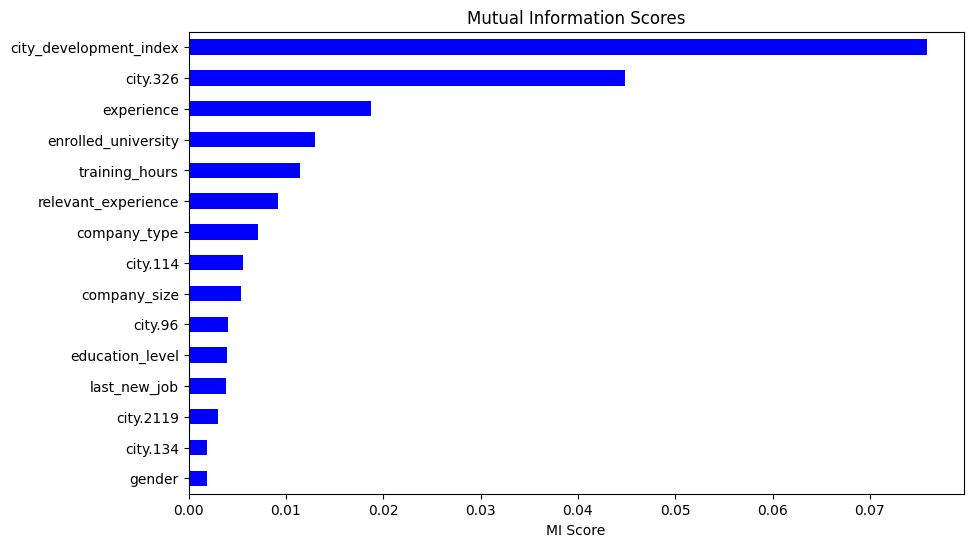

In [503]:
miScores = mutual_info_classif(changeJobDf[featureCols], changeJobDf['target'], discrete_features=True, random_state=42)
miSeries = pd.Series(miScores, index=changeJobDf[featureCols].columns)
miSeries = miSeries.sort_values(ascending=False)

# 4. Plot
plt.figure(figsize=(10, 6))
miSeries.head(15).plot(kind='barh', color='blue')
plt.title("Mutual Information Scores")
plt.xlabel("MI Score")
plt.gca().invert_yaxis()
plt.show()

## Modelling

In [504]:
# Designated features as x and target as y
x = changeJobDf[featureCols]
y = changeJobDf['target']

### Functions

In [505]:
def plot_feature_importance(model, featureNames, topN):
    imp = pd.Series(model.feature_importances_, index=featureNames)
    imp.nlargest(topN).sort_values().plot(kind='barh', figsize=(10, 6), title="Feature Importance")
    plt.show()

def plot_confusion_matrix(yTrue, yPred, labels=["No", "Yes"]):
    cm = confusion_matrix(yTrue, yPred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    plt.title('Confusion Matrix')
    plt.show()

## Random Forest


--- Baseline Performance (All Features) ---
F1 Score: 0.5451

--- Top 30 Feature Importances ---


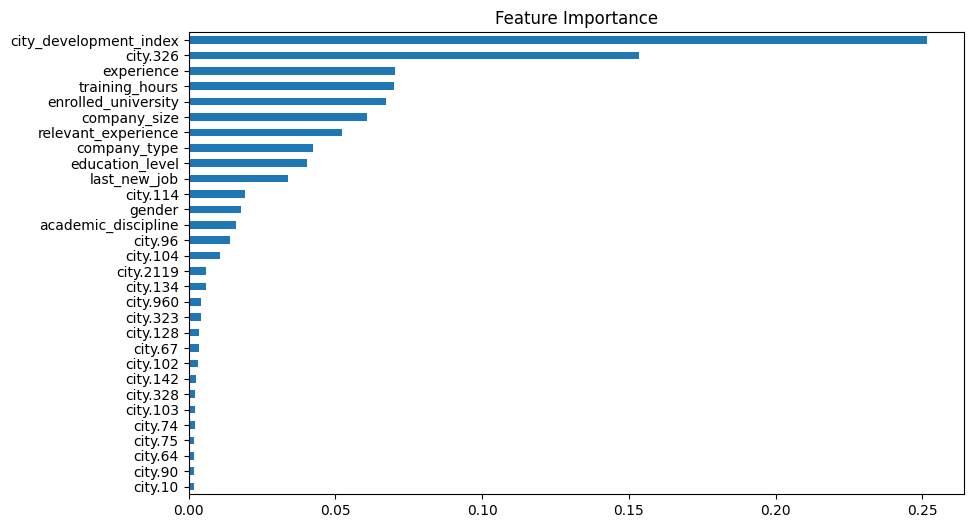


--- Comparing Baseline vs. Trimmed Model ---
Top 30 Features selected: ['city_development_index', 'city.326', 'experience', 'training_hours', 'enrolled_university', 'company_size', 'relevant_experience', 'company_type', 'education_level', 'last_new_job', 'city.114', 'gender', 'academic_discipline', 'city.96', 'city.104', 'city.2119', 'city.134', 'city.960', 'city.323', 'city.128', 'city.67', 'city.102', 'city.142', 'city.328', 'city.103', 'city.74', 'city.75', 'city.64', 'city.90', 'city.10']
Baseline F1: 0.5451
Trimmed F1:  0.5421
>>> Applying TRIMMED Model - Top 30 features

--- Starting Hyperparameter Tuning (Grid Search) ---
Tuning on 30 features...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best Parameters: {'class_weight': 'balanced_subsample', 'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}
Best CV F1 Score: 0.5674

--- Final Test Set Performance ---
Precision: 0.5477
Recall: 0.6206
F1 Score: 0.5819

Confusion Matrix:


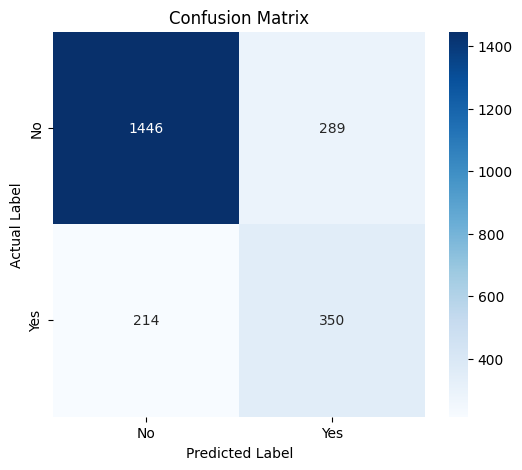

--- Non-numeric Field Post Transformation Values ---
gender: [1 0 2]
enrolled_university: [1 0 2]
education_level: [3 2 1 4 0]
academic_discipline: [5 1 2 4 3 0]
experience: [21  2 15 13  6  0 19  4 14 10 16  1 11 20 17  7  3 18  5 12  8  9]
company_size: [6 3 1 5 0 4 2 7]
company_type: [5 3 4 2 1 0]
last_new_job: [5 2 0 3 1 4]
relevant_experience: [0 1]
target: [0]
Generating predictions...
Submission Saved...


In [506]:
# ============================================================
# --- STEP 1: Data Split and Hold out Set ---
# ============================================================

from sklearn.model_selection import train_test_split

# 1. FINAL Test Set (20%)
xTrainFull, xTest, yTrainFull, yTest = train_test_split(
    x, y, test_size=0.2, random_state=42, stratify=y
)

# 2. HOLD-OUT Validation Set (20% of the 80%)
xTrain, xVal, yTrain, yVal = train_test_split(
    xTrainFull, yTrainFull, test_size=0.2, random_state=42, stratify=yTrainFull
)


# ============================================================
# --- STEP 2: BASELINE RANDOM FOREST MODEL ---
# ============================================================

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

rfModel = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

rfModel.fit(xTrain, yTrain)

yValPred = rfModel.predict(xVal)
f1Val = f1_score(yVal, yValPred)

print("\n--- Baseline Performance (All Features) ---")
print(f"F1 Score: {f1Val:.4f}")


# ============================================================
# --- STEP 3: VISUALISE INFORMATION GAIN ---
# ============================================================

importances = rfModel.feature_importances_
feature_df = pd.DataFrame({'Feature': xTrain.columns, 'Importance': importances})

print("\n--- Top 30 Feature Importances ---")
plot_feature_importance(rfModel, xTrain.columns, topN=30)


# ============================================================
# --- STEP 3.5: MODEL SELECTION (Baseline vs Top 30) ---
# ============================================================

print("\n--- Comparing Baseline vs. Trimmed Model ---")

feature_names = xTrain.columns
sortedFeatures = sorted(
    zip(feature_names, importances),
    key=lambda x: x[1],
    reverse=True
)[:30]

top30Features = [k for k, _ in sortedFeatures]
print(f"Top 30 Features selected: {top30Features}")

# Trim datasets
xTrainTrimmed = xTrain[top30Features]
xValTrimmed = xVal[top30Features]

rfTrimmed = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

rfTrimmed.fit(xTrainTrimmed, yTrain)
yValPredTrimmed = rfTrimmed.predict(xValTrimmed)
f1Trimmed = f1_score(yVal, yValPredTrimmed)

print(f"Baseline F1: {f1Val:.4f}")
print(f"Trimmed F1:  {f1Trimmed:.4f}")

# Decide whether to use all or top30
if f1Trimmed >= (f1Val - 0.01):
    print(">>> Applying TRIMMED Model - Top 30 features")
    xTrainFull = xTrainFull[top30Features]
    xTest = xTest[top30Features]
else:
    print(">>> Applying BASELINE Model - All features")


# ============================================================
# --- STEP 4: HYPERPARAMETER TUNING ---
# ============================================================

from sklearn.model_selection import GridSearchCV

print("\n--- Starting Hyperparameter Tuning (Grid Search) ---")
print(f"Tuning on {xTrainFull.shape[1]} features...")

paramGrid = {
    "n_estimators": [100, 300],
    "max_depth": [5, 10, 15],
    "min_samples_split": [2, 5, 10],
    "class_weight": ["balanced", "balanced_subsample"]
}

rfGrid = RandomForestClassifier(random_state=42, n_jobs=-1)

gridSearch = GridSearchCV(
    estimator=rfGrid,
    param_grid=paramGrid,
    scoring="f1",
    cv=3,
    verbose=1,
    n_jobs=-1,
)

gridSearch.fit(xTrainFull, yTrainFull)

print(f"Best Parameters: {gridSearch.best_params_}")
print(f"Best CV F1 Score: {gridSearch.best_score_:.4f}")


# ============================================================
# --- STEP 5: FINAL EVALUATION ---
# ============================================================

from sklearn.metrics import precision_score, recall_score

bestModel = gridSearch.best_estimator_
yTestPred = bestModel.predict(xTest)

rfPrecision = precision_score(yTest, yTestPred)
rfRecall = recall_score(yTest, yTestPred)
rfF1 = f1_score(yTest, yTestPred)

print("\n--- Final Test Set Performance ---")
print(f"Precision: {rfPrecision:.4f}")
print(f"Recall: {rfRecall:.4f}")
print(f"F1 Score: {rfF1:.4f}")

print("\nConfusion Matrix:")
plot_confusion_matrix(yTest, yTestPred, labels=["No", "Yes"])


# ============================================================
# --- STEP 6: PREDICT ON SUBMISSION DATA ---
# ============================================================

submissionDf = pd.read_csv("A2_change_job_submission.csv")
xModelInput = submissionDf.copy()

# Drop ID
if 'cid' in xModelInput.columns:
    xModelInput = xModelInput.drop(columns=['cid'])

# --- USE YOUR ENCODING FUNCTION HERE ---
# Must pass the same nonNumericCols used during training
xModelInput = encode_change_job_df(xModelInput, nonNumericCols)

# Filter to required features (same order as training)
features = xTrainFull.columns
xModelInput = xModelInput[features]

# Predict
print("Generating predictions...")
predictionsNumeric = bestModel.predict(xModelInput)

predictions_label = np.where(predictionsNumeric == 1, 'yes', 'no')
submissionDf['target'] = predictions_label

submissionDf.to_csv('final_submission_full.csv', index=False)
print("Submission Saved...")